In [147]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

In [148]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

NFOLDS = 10
SEED = 7

### Load data

#### Load table with language features

In [149]:
lang_feats = pd.read_excel("../../xtreme_langs_wals.xlsx", index_col=0)

In [150]:
lang_feats.head()

,ISO 693-2,wals_code,iso_code,glottocode,Name,latitude,longitude,genus,family,#feats,macroarea,countrycodes,20A Fusion of Selected Inflectional Formatives,21A Exponence of Selected Inflectional Formatives,22A Inflectional Synthesis of the Verb,23A Locus of Marking in the Clause,24A Locus of Marking in Possessive Noun Phrases,25A Locus of Marking: Whole-language Typology,26A Prefixing vs. Suffixing in Inflectional Morphology,27A Reduplication,28A Case Syncretism,29A Syncretism in Verbal Person/Number Marking,30A Number of Genders,31A Sex-based and Non-sex-based Gender Systems,32A Systems of Gender Assignment,33A Coding of Nominal Plurality,34A Occurrence of Nominal Plurality,35A Plurality in Independent Personal Pronouns,36A The Associative Plural,37A Definite Articles,38A Indefinite Articles,39A Inclusive/Exclusive Distinction in Independent Pronouns,40A Inclusive/Exclusive Distinction in Verbal Inflection,41A Distance Contrasts in Demonstratives,42A Pronominal and Adnominal Demonstratives,43A Third Person Pronouns and Demonstratives,44A Gender Distinctions in Independent Personal Pronouns,45A Politeness Distinctions in Pronouns,46A Indefinite Pronouns,47A Intensifiers and Reflexive Pronouns,48A Person Marking on Adpositions,49A Number of Cases,50A Asymmetrical Case-Marking,51A Position of Case Affixes,52A Comitatives and Instrumentals,53A Ordinal Numerals,54A Distributive Numerals,55A Numeral Classifiers,56A Conjunctions and Universal Quantifiers,57A Position of Pronominal Possessive Affixes,58A Obligatory Possessive Inflection,59A Possessive Classification,"60A Genitives, Adjectives and Relative Clauses",61A Adjectives without Nouns,62A Action Nominal Constructions,63A Noun Phrase Conjunction,64A Nominal and Verbal Conjunction,65A Perfective/Imperfective Aspect,66A The Past Tense,67A The Future Tense,68A The Perfect,69A Position of Tense-Aspect Affixes,70A The Morphological Imperative,71A The Prohibitive,72A Imperative-Hortative Systems,73A The Optative,74A Situational Possibility,75A Epistemic Possibility,76A Overlap between Situational and Epistemic Modal Marking,77A Semantic Distinctions of Evidentiality,78A Coding of Evidentiality,79A Suppletion According to Tense and Aspect,80A Verbal Number and Suppletion,"81A Order of Subject, Object and Verb",82A Order of Subject and Verb,83A Order of Object and Verb,"84A Order of Object, Oblique, and Verb",85A Order of Adposition and Noun Phrase,86A Order of Genitive and Noun,87A Order of Adjective and Noun,88A Order of Demonstrative and Noun,89A Order of Numeral and Noun,90A Order of Relative Clause and Noun,91A Order of Degree Word and Adjective,92A Position of Polar Question Particles,93A Position of Interrogative Phrases in Content Questions,94A Order of Adverbial Subordinator and Clause,95A Relationship between the Order of Object and Verb and the Order of Adposition and Noun Phrase,96A Relationship between the Order of Object and Verb and the Order of Relative Clause and Noun,97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun,98A Alignment of Case Marking of Full Noun Phrases,99A Alignment of Case Marking of Pronouns,100A Alignment of Verbal Person Marking,101A Expression of Pronominal Subjects,102A Verbal Person Marking,103A Third Person Zero of Verbal Person Marking,104A Order of Person Markers on the Verb,105A Ditransitive Constructions: The Verb 'Give',106A Reciprocal Constructions,107A Passive Constructions,108A Antipassive Constructions,109A Applicative Constructions,110A Periphrastic Causative Constructions,111A Nonperiphrastic Causative Constructions,112A Negative Morphemes,113A Symmetric and Asymmetric Standard Negation,114A Subtypes of Asymmetric Standard Negation,115A Negative Indefinite Pronouns and Predicate Negation,116A Polar Questions,117A Predicative Possession,118A Predicative Adjectives,119A Nominal and Locational Predication,120A Zero Copula for Predicate Nominals,121A Comparative Constructions,122A Relativization on S

In [151]:
lang_feats.shape

(40, 185)

Delete columns that are totally empty

For each feature check how many non-empty cells it has (how many languages have this feature)

In [152]:
l = lang_feats.count().sort_values()

In [153]:
l[l>10].shape

(154,)

Display unique values of selected features

In [154]:
cols = ['22A Inflectional Synthesis of the Verb','30A Number of Genders','29A Syncretism in Verbal Person/Number Marking','43A Third Person Pronouns and Demonstratives']
for col in cols:
    print("Column",col)
    print("Values:")
    for val in sorted(lang_feats[col].dropna().unique(), key=lambda element: [element[0]]):
        print(val)
    print()

Column 22A Inflectional Synthesis of the Verb
Values:
1 0-1 category per word
2 2-3 categories per word
3 4-5 categories per word
4 6-7 categories per word
5 8-9 categories per word

Column 30A Number of Genders
Values:
1 None
2 Two
3 Three
5 Five or more

Column 29A Syncretism in Verbal Person/Number Marking
Values:
1 No subject person/number marking
2 Syncretic
3 Not syncretic

Column 43A Third Person Pronouns and Demonstratives
Values:
1 Unrelated
2 Related for all demonstratives
3 Related to remote demonstratives
5 Related by gender markers
6 Related for non-human reference



#### Load language pairs with scores

In [155]:
pair_scores = pd.read_csv("lang_pair_scores.csv")

In [156]:
pair_scores.head()

,train_lang,test_lang,acc,f1
0,af,af,0.984390,0.982330
1,af,ar,0.587932,0.517718
2,af,bg,0.847598,0.834094
3,af,de,0.837953,0.828865
4,af,el,0.800967,0.779682


In [157]:
feat_cols = lang_feats.columns[12:]

In [158]:
final_arr = []


for i in pair_scores.index:
    train_lang = pair_scores.at[i,"train_lang"]
    test_lang = pair_scores.at[i,"test_lang"]
    train_feats =  list(pair_scores.iloc[i,:].values) + list(lang_feats.loc[train_lang,feat_cols].values) + list(lang_feats.loc[test_lang,feat_cols].values)
    final_arr.append(train_feats)

    
feat_cols = [col.split()[0]+"_train" for col in feat_cols]+ [col.split()[0]+"_test" for col in feat_cols]
final_cols = list(pair_scores.columns)+feat_cols
final_df = pd.DataFrame(data=final_arr,columns=final_cols)

In [159]:
final_df.head() 

,train_lang,test_lang,acc,f1,20A_train,21A_train,22A_train,23A_train,24A_train,25A_train,26A_train,27A_train,28A_train,29A_train,30A_train,31A_train,32A_train,33A_train,34A_train,35A_train,36A_train,37A_train,38A_train,39A_train,40A_train,41A_train,42A_train,43A_train,44A_train,45A_train,46A_train,47A_train,48A_train,49A_train,50A_train,51A_train,52A_train,53A_train,54A_train,55A_train,56A_train,57A_train,58A_train,59A_train,60A_train,61A_train,62A_train,63A_train,64A_train,65A_train,66A_train,67A_train,68A_train,69A_train,70A_train,71A_train,72A_train,73A_train,74A_train,75A_train,76A_train,77A_train,78A_train,79A_train,80A_train,81A_train,82A_train,83A_train,84A_train,85A_train,86A_train,87A_train,88A_train,89A_train,90A_train,91A_train,92A_train,93A_train,94A_train,95A_train,96A_train,97A_train,98A_train,99A_train,100A_train,101A_train,102A_train,103A_train,104A_train,105A_train,106A_train,107A_train,108A_train,109A_train,110A_train,111A_train,112A_train,113A_train,114A_train,115A_train,116A_train,117A_train,118A_train,119A_train,120A_train,121A_train,122A_train,123A_train,124A_train,125A_train,126A_train,127A_train,128A_train,129A_train,130A_train,131A_train,132A_train,133A_train,134A_train,135A_train,136A_train,137A_train,138A_train,139A_train,140A_train,141A_train,142A_train,143F_train,90B_train,144Y_train,90C_train,144P_train,144J_train,144N_train,144S_train,144X_train,144A_train,90G_train,90E_train,144V_train,144I_train,144R_train,143B_train,144M_train,144U_train,144G_train,144K_train,144B_train,144F_train,90D_train,144E_train,144D_train,81B_train,143E_train,143C_train,90F_train,143A_train,144W_train,144O_train,144Q_train,144L_train,144H_train,144C_train,144T_train,143G_train,143D_train,39B_train,137B_train,136B_train,109B_train,10B_train,25B_train,21B_train,108B_train,130B_train,58B_train,79B_train,20A_test,21A_test,22A_test,23A_test,24A_test,25A_test,26A_test,27A_test,28A_test,29A_test,30A_test,31A_test,32A_test,33A_test,34A_test,35A_test,36A_test,37A_test,38A_test,39A_test,40A_test,41A_test,42A_test,43A_test,44A_test,45A_test,46A_test,47A_test,48A_test,49A_test,50A_test,51A_test,52A_test,53A_test,54A_test,55A_test,56A_test,57A_test,58A_test,59A_test,60A_test,61A_test,62A_test,63A_test,64A_test,65A_test,66A_test,67A_test,68A_test,69A_test,70A_test,71A_test,72A_test,73A_test,74A_test,75A_test,76A_test,77A_test,78A_test,79A_test,80A_test,81A_test,82A_test,83A_test,84A_test,85A_test,86A_test,87A_test,88A_test,89A_test,90A_test,91A_test,92A_test,93A_test,94A_test,95A_test,96A_test,97A_test,98A_test,99A_test,100A_test,101A_test,102A_test,103A_test,104A_test,105A_test,106A_test,107A_test,108A_test,109A_test,110A_test,111A_test,112A_test,113A_test,114A_test,115A_test,116A_test,117A_test,118A_test,119A_test,120A_test,121A_test,122A_test,123A_test,124A_test,125A_test,126A_test,127A_test,128A_test,129A_test,130A_test,131A_test,132A_test,133A_test,134A_test,135A_test,136A_test,137A_test,138A_test,139A_test,140A_test,141A_test,142A_test,143F_test,90B_test,144Y_test,90C_test,144P_test,144J_test,144N_test,144S_test,144X_test,144A_test,90G_test,90E_test,144V_test,144I_test,144R_test,143B_test,144M_test,144U_test,144G_test,144K_test,144B_test,144F_test,90D_test,144E_test,144D_test,81B_test,143E_test,143C_test,90F_test,143A_test,144W_test,144O_test,144Q_test,144L_test,144H_test,144C_test,144T_test,143G_test,143D_test,39B_test,137B_test,136B_test,109B_test,10B_test,25B_test,21B_test,108B_test,130B_test,58B_test,79B_test
0,af,af,0.984390,0.982330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3 Unique periphrastic associative plural,NaN,NaN,NaN,NaN,2 Two-way contrast,1 Identical,NaN,NaN,NaN,NaN,1 Identical,NaN,NaN,NaN,NaN,1 Identity,"6 First, two-th, three-th",1 No distributive numerals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 No grammatical marking,"1 Present, no remoteness distinctions",2 No inflectional future,"2 From 'finish', 'already'",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Indirect only,4 Separate particle,NaN,NaN,N

In [160]:
final_df.train_lang.nunique()

29

In [161]:
final_df = final_df.dropna(axis=1,how='all')

### Fill missing values

In [162]:
cat_cols = list(final_df.select_dtypes(include=['object']).columns)

In [163]:
# TODO change df name in this line and below
final_df[cat_cols] = final_df[cat_cols].fillna("0 Missing")

In [164]:
final_df.isna().any().any()

False

### Encode categorical variables (i.e. all of them)

In [165]:
mappings = []
for col in cat_cols:
    unique_vals = final_df[col].unique()
#     every value starts with an index number, additionally we mark missing as 0
    sorted_vals = sorted(unique_vals, key=lambda element: [element[0]])
    mappings.append(sorted_vals)
    

In [166]:
oe = OrdinalEncoder(categories=mappings)
oe.fit(final_df[cat_cols])
final_df[cat_cols] = oe.transform(final_df[cat_cols])

### Functions for training and evaluation

In [167]:
def fold_metrics(model, x_train, y_train, x_val, y_val, metrics_dict,debug=False): 
    y_preds = model.predict(x_train)
    fold_train = np.sqrt(mean_squared_error(y_train,y_preds))
    
    y_preds_val = model.predict(x_val)
    fold_val = np.sqrt(mean_squared_error(y_val,y_preds_val))


    
    metrics_dict['train']['rmse'].append(fold_train)
    metrics_dict['test']['rmse'].append(fold_val)
    
    if debug:
        metrics = pd.DataFrame.from_dict({'train':[fold_train],
                                         'test':[fold_val]})
        metrics.index = ['rmse']
        display(metrics)

In [168]:
def mean_fold_metrics(metrics_dict):
    
    train_rmse = np.mean(metrics_dict['train']['rmse'])
    test_rmse = np.mean(metrics_dict['test']['rmse'])
                        
    metrics = pd.DataFrame.from_dict({'train':[train_rmse],'test':[test_rmse]})
    metrics.index = ['rmse']
    
    print()
    print("Mean fold metrics")
    display(metrics)
    return metrics

In [169]:
def train_model(X, y, folds, params=None, X_test=None, model_type='lgb',n_jobs=-1, n_estimators=None, plot_feature_importance=True, verbose=500,early_stopping_rounds=None):
#     add n_estimators and early_stopping as arguments in lgbm
    print("Model type",model_type)
    metrics_dict = {'train':{'rmse':[]},
                   'test':{'rmse':[]}}
    result_dict = {}
    n_splits = folds.n_splits
    columns = X.columns
    # averaged predictions on test data
    if X_test is not None:
        prediction = np.zeros((len(X_test), 1))
    
    feature_importance = pd.DataFrame()
    
    if params is None:
        params = {}
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
#         print('Fold nr {}'.format(fold_n))
        X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        if model_type=='lgb':
            model = lgb.LGBMClassifier(**params, importance_type='gain')
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='rmse',
                    verbose=verbose)
    #         we want 0s and 1s for submission
            if X_test is not None:
                y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
        elif model_type=='xgb':
            model = xgb.XGBRegressor(**params,random_state=SEED)
            model.fit(X_train, y_train)
            #         we want 0s and 1s for submission
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='linear':
            model = LinearRegression()
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='lasso':
            model = Lasso(random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='dt':
            model = DecisionTreeRegressor(max_depth=10,max_leaf_nodes=10,random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        elif model_type=='rf':
            model = RandomForestRegressor(random_state=SEED)
            model.fit(X_train,y_train)
            if X_test is not None:
                y_pred = model.predict(X_test)
        else:
            raise Exception("Invalid model type")
                    
        fold_metrics(model,X_train,y_train,X_valid,y_valid,metrics_dict)
        
        if X_test is not None:
            prediction += y_pred.reshape(-1, 1)
        if plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    
    
    if X_test is not None:
        prediction /= n_splits
    
    result_dict['metrics'] = mean_fold_metrics(metrics_dict)
    if X_test is not None:
        result_dict['prediction'] = prediction.flatten()
        
    
    if plot_feature_importance:
        feature_importance["importance"] /= n_splits
        best_features = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].reset_index(level=['feature'])


        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features);
        plt.title('{} Features (avg over folds)'.format(model_type.upper()));

        result_dict['feature_importance'] = feature_importance
        result_dict['top_columns'] = best_features['feature'].unique()
        
    return result_dict, model

### Train models

In [170]:
folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

#### On all features

In [233]:
X = final_df.drop(['acc','f1'],axis=1)
y = final_df['acc']

Try different models and compare results

In [172]:
for est in ['linear','lasso','dt','rf','xgb']:
    results, model = train_model(X,y,folds,params=None,model_type=est,plot_feature_importance=False)

Model type linear

Mean fold metrics


,train,test
rmse,0.084318,0.089687


Model type lasso

Mean fold metrics


,train,test
rmse,0.160683,0.16037


Model type dt

Mean fold metrics


,train,test
rmse,0.084544,0.093085


Model type rf

Mean fold metrics


,train,test
rmse,0.025791,0.068978


Model type xgb

Mean fold metrics


,train,test
rmse,0.002211,0.068593


The best results are obtained by Random Forest

### Analysing feature importance

In [235]:
X.columns

Index(['train_lang', 'test_lang', '20A_train', '21A_train', '22A_train',
       '23A_train', '24A_train', '25A_train', '26A_train', '27A_train',
       ...
       '144T_test', '143G_test', '137B_test', '136B_test', '109B_test',
       '25B_test', '21B_test', '108B_test', '58B_test', '79B_test'],
      dtype='object', length=318)

Model type rf

Mean fold metrics


,train,test
rmse,0.025791,0.068978


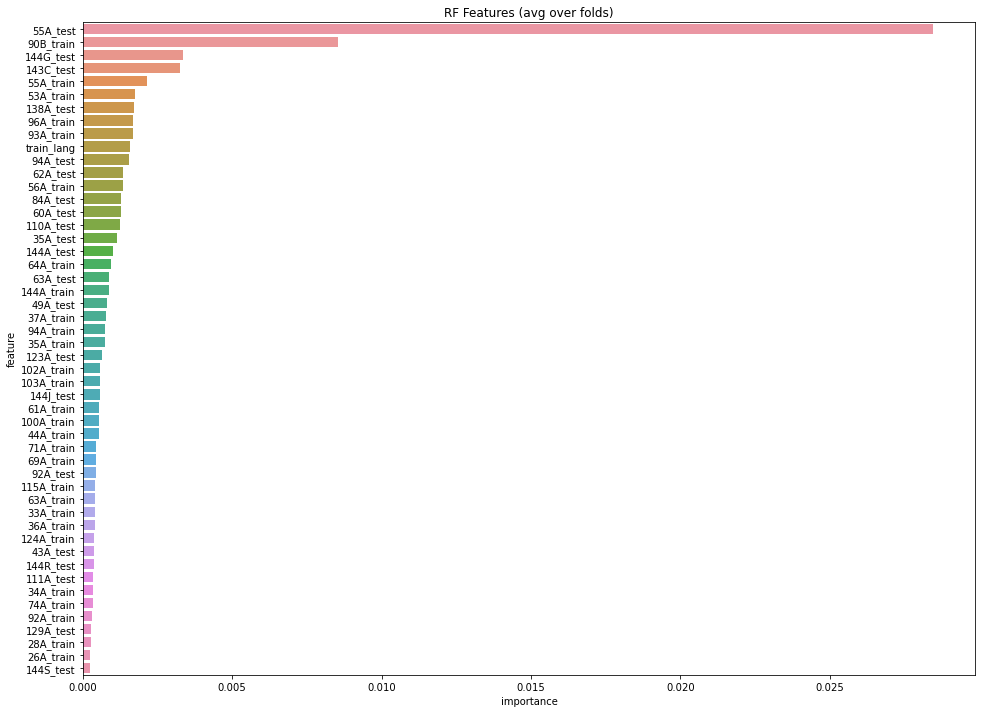

In [234]:
results, model = train_model(X,y,folds,params=None,model_type='rf',plot_feature_importance=True)

"55A_test" and "90B_train" are signficantly more important than other languages. Their full names are '55A Numeral Classifiers' and 90B Prenominal relative clauses.

Below we can see a visualization of a decision tree.

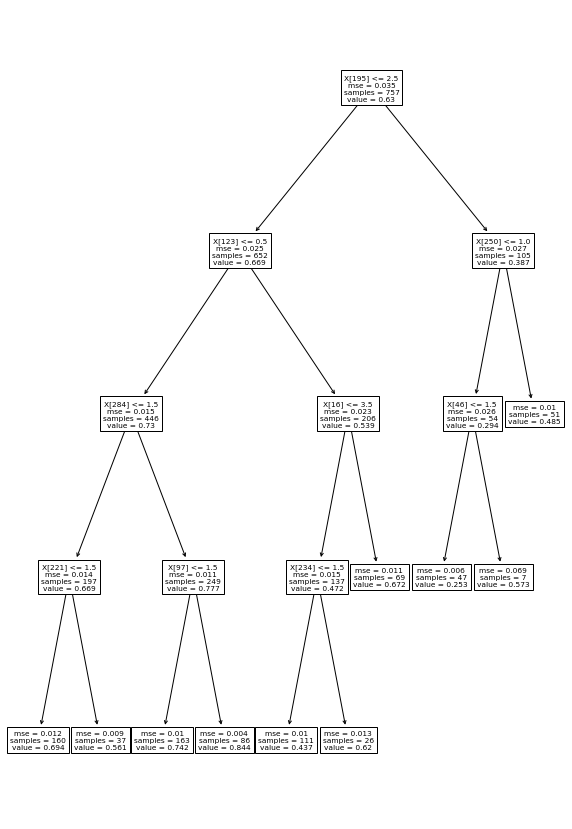

In [61]:
plt.figure(figsize=(10,15))
tree.plot_tree(model);

In [105]:
X.columns[[195, 123, 259]]

Index(['55A_test', '90B_train', '119A_test'], dtype='object')

The two most important features are the same as for Random Forest. 

In [108]:
lang_feats['55A Numeral Classifiers'].value_counts()

1 Absent        15
3 Obligatory     7
2 Optional       5
Name: 55A Numeral Classifiers, dtype: int64

In [109]:
lang_feats['90B Prenominal relative clauses'].value_counts()

1 Relative clause-Noun (RelN) dominant    10
2 RelN or NRel                             1
Name: 90B Prenominal relative clauses, dtype: int64

For the first one the split is between 2 and 3 (therefore between "Obligatory" and other classes. For the second one, the split is between 0 and 1 (there between missing value and other classes).

In [110]:
lang_feats[lang_feats['55A Numeral Classifiers']=='3 Obligatory'].Name.values

array(['Bengali', 'Japanese', 'Korean', 'Burmese', 'Thai', 'Vietnamese',
       'Mandarin'], dtype=object)

In [111]:
lang_feats[lang_feats["90B Prenominal relative clauses"].notna()].Name.values

array(['Basque', 'Hungarian', 'Japanese', 'Korean', 'Malayalam',
       'Marathi', 'Burmese', 'Tamil', 'Telugu', 'Turkish', 'Mandarin'],
      dtype=object)

In [112]:
lang_feats[lang_feats["90B Prenominal relative clauses"].isna()].Name.values

array(['Afrikaans', 'Arabic (Modern Standard)', 'Bulgarian', 'Bengali',
       'German', 'Greek (Modern)', 'English', 'Spanish', 'Estonian',
       'Persian', 'Finnish', 'French', 'Hebrew (Modern)', 'Hindi',
       'Indonesian', 'Italian', 'Javanese', 'Georgian', 'Kazakh', 'Malay',
       'Dutch', 'Portuguese', 'Russian', 'Swahili', 'Thai', 'Tagalog',
       'Urdu', 'Vietnamese', 'Yoruba'], dtype=object)

We can see that the languages with obligatory numeral classifiers are all from South-West Asia. On the other hand languages with missing feature 90B are usually European, while those that are not missing it are Asian.

#### By feature group

In [223]:
groups = {"morphology":list(range(20,30)),
"nom_cat":list(range(30, 58)),
"nom_synt":list(range(58, 65)),
"verb_cat":list(range(65, 81)),
"order":list(range(81, 98))+[143, 144],
"simp_claus":list(range(98, 122)),
"comp_sent":list(range(122, 129)),
"lexicon":list(range(129, 139)),
"other":list(range(141,143)),}


In [224]:
final_df.columns[4:]

Index(['20A_train', '21A_train', '22A_train', '23A_train', '24A_train',
       '25A_train', '26A_train', '27A_train', '28A_train', '29A_train',
       ...
       '144T_test', '143G_test', '137B_test', '136B_test', '109B_test',
       '25B_test', '21B_test', '108B_test', '58B_test', '79B_test'],
      dtype='object', length=316)

Group morphology
Model type rf

Mean fold metrics


,train,test
rmse,0.073878,0.10241


Group nom_cat
Model type rf

Mean fold metrics


,train,test
rmse,0.02745,0.074974


Group nom_synt
Model type rf

Mean fold metrics


,train,test
rmse,0.073063,0.111601


Group verb_cat
Model type rf

Mean fold metrics


,train,test
rmse,0.031393,0.082556


Group order
Model type rf

Mean fold metrics


,train,test
rmse,0.027183,0.06899


Group simp_claus
Model type rf

Mean fold metrics


,train,test
rmse,0.029334,0.07797


Group comp_sent
Model type rf

Mean fold metrics


,train,test
rmse,0.0875,0.118852


Group lexicon
Model type rf

Mean fold metrics


,train,test
rmse,0.063432,0.101026


Group other
Model type rf

Mean fold metrics


,train,test
rmse,0.156374,0.157548


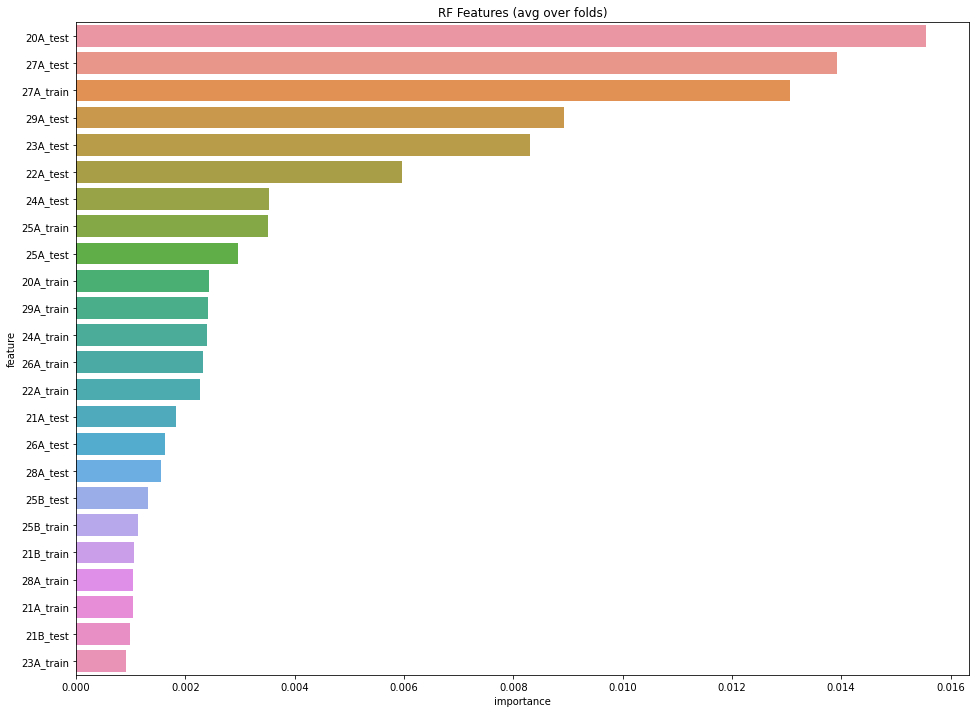

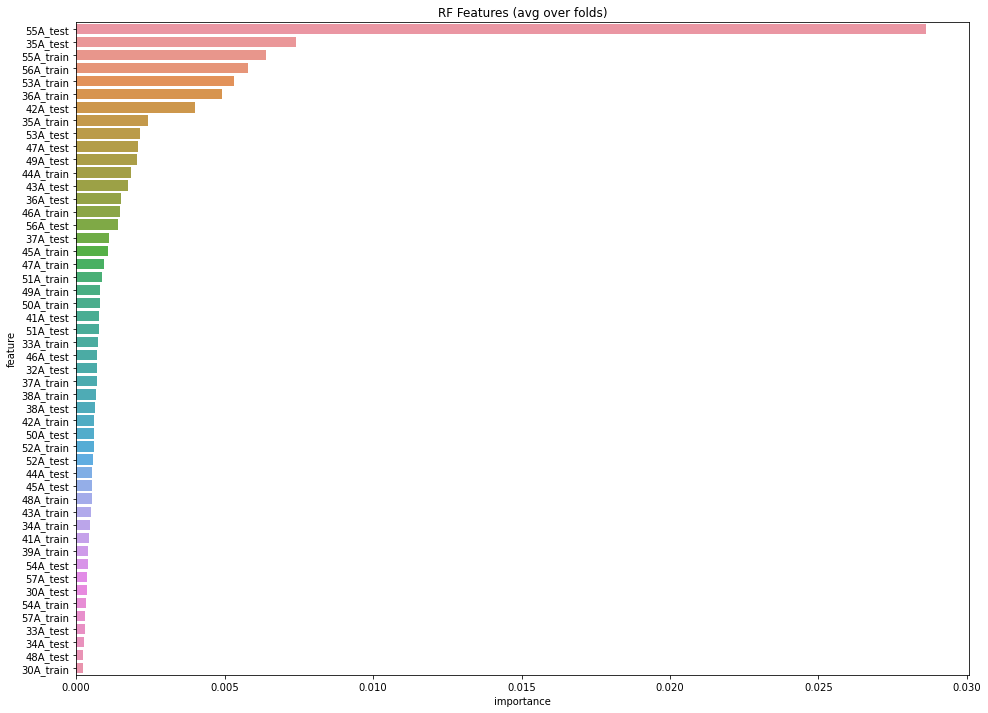

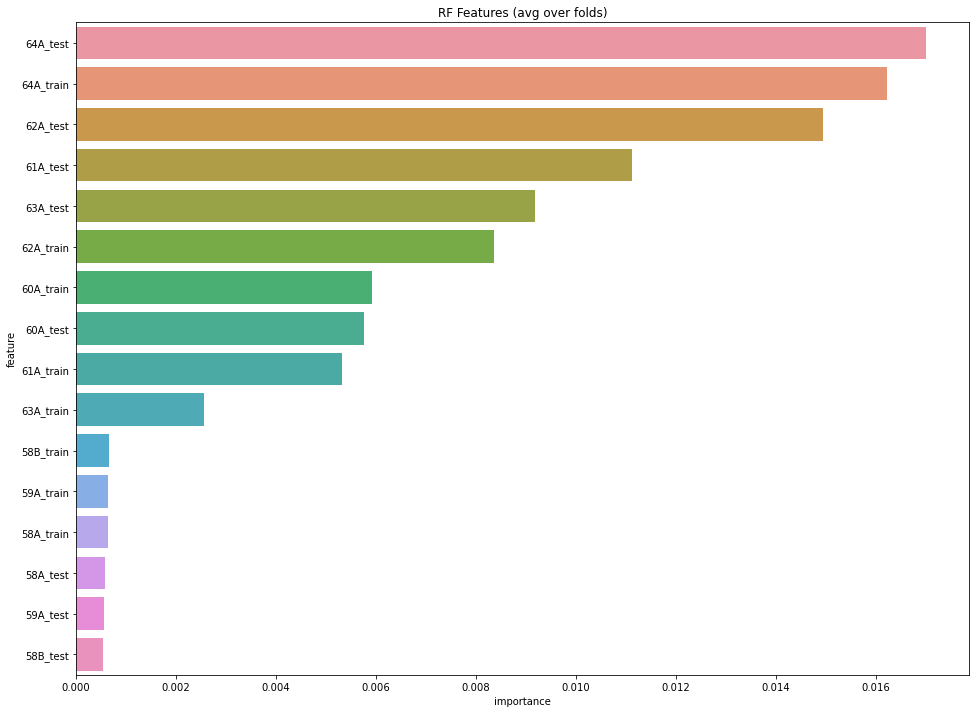

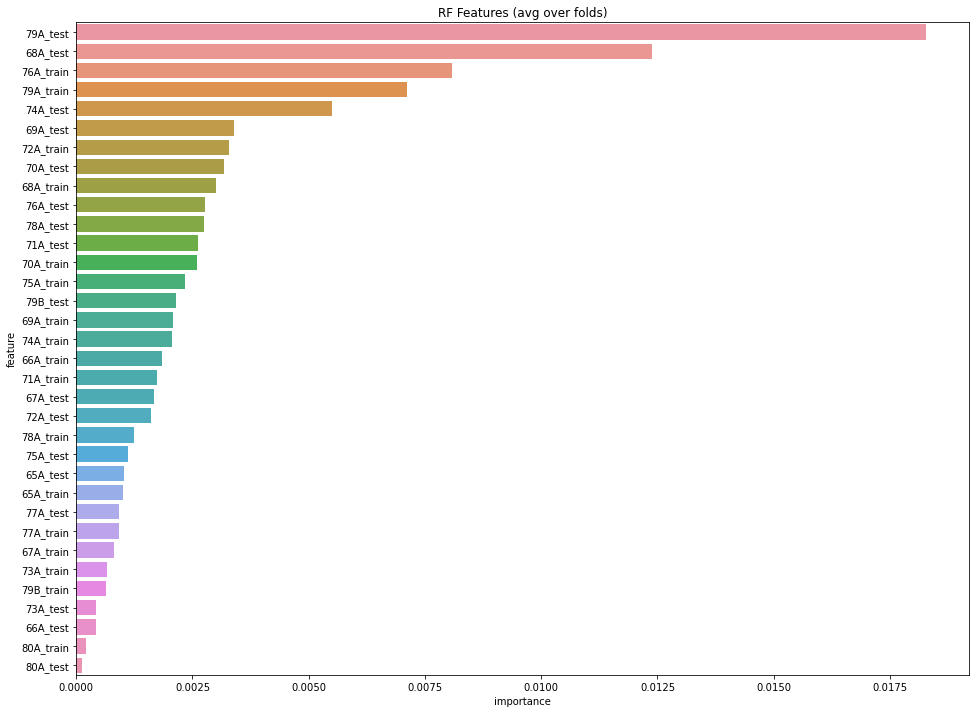

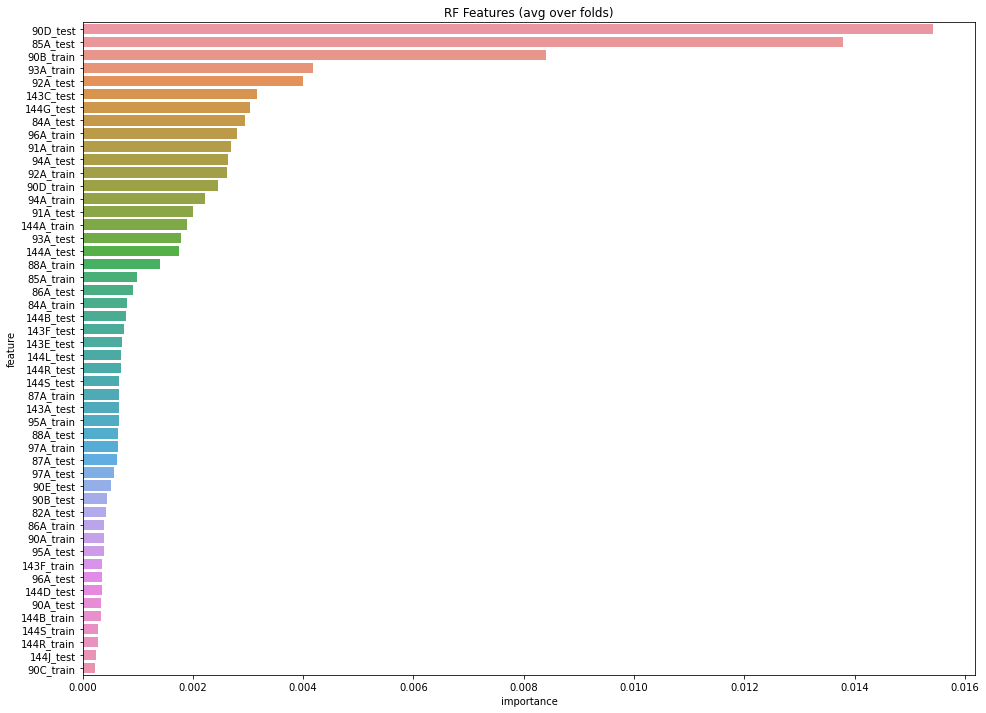

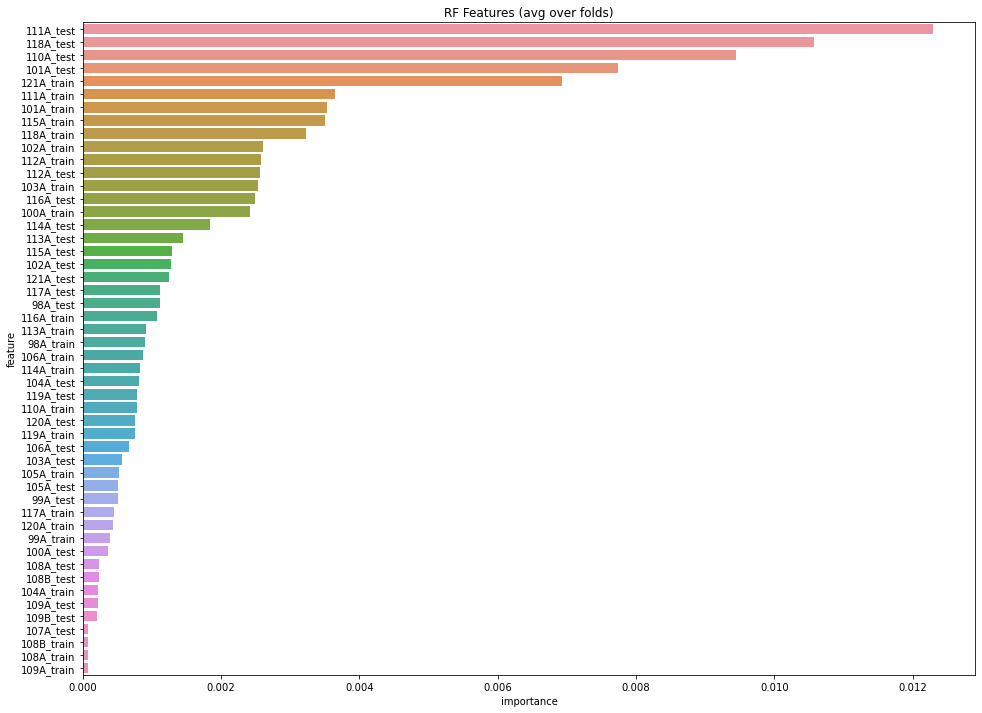

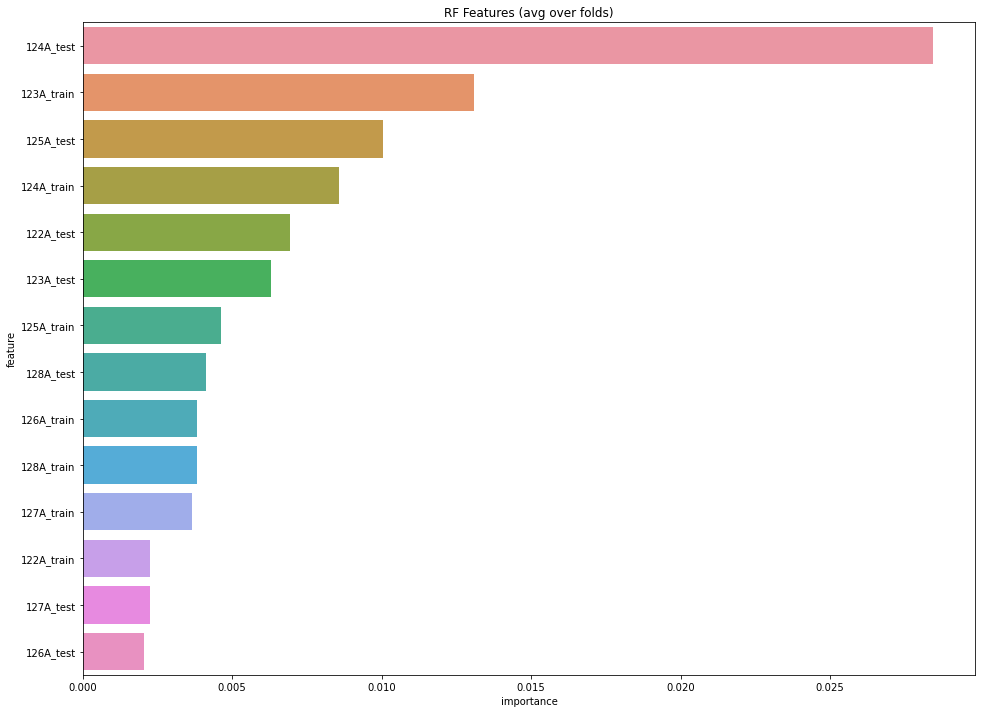

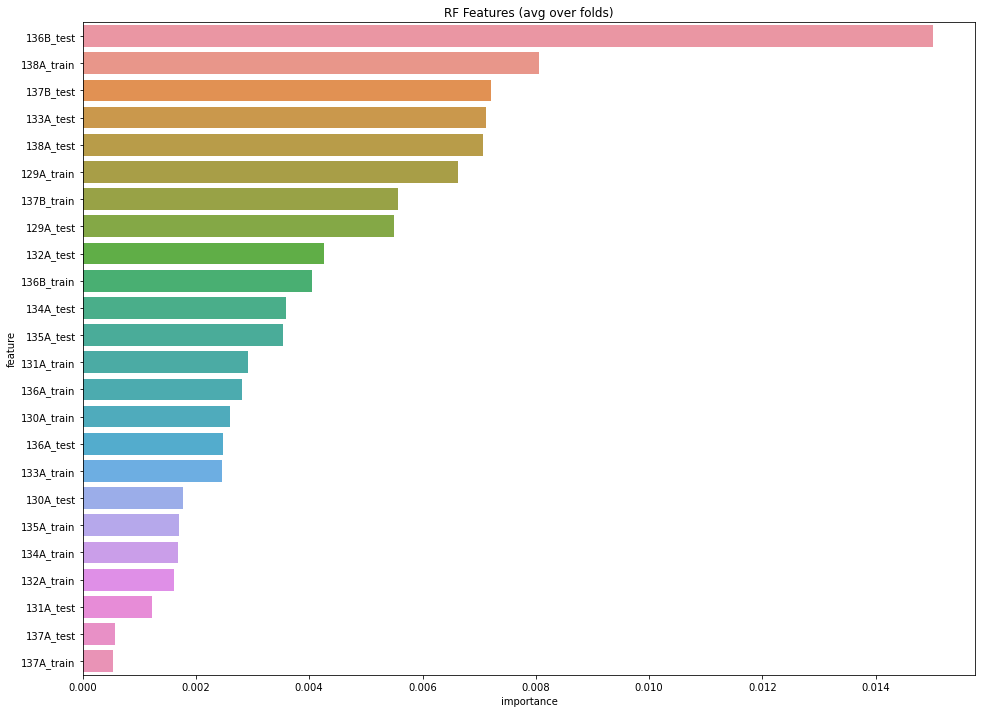

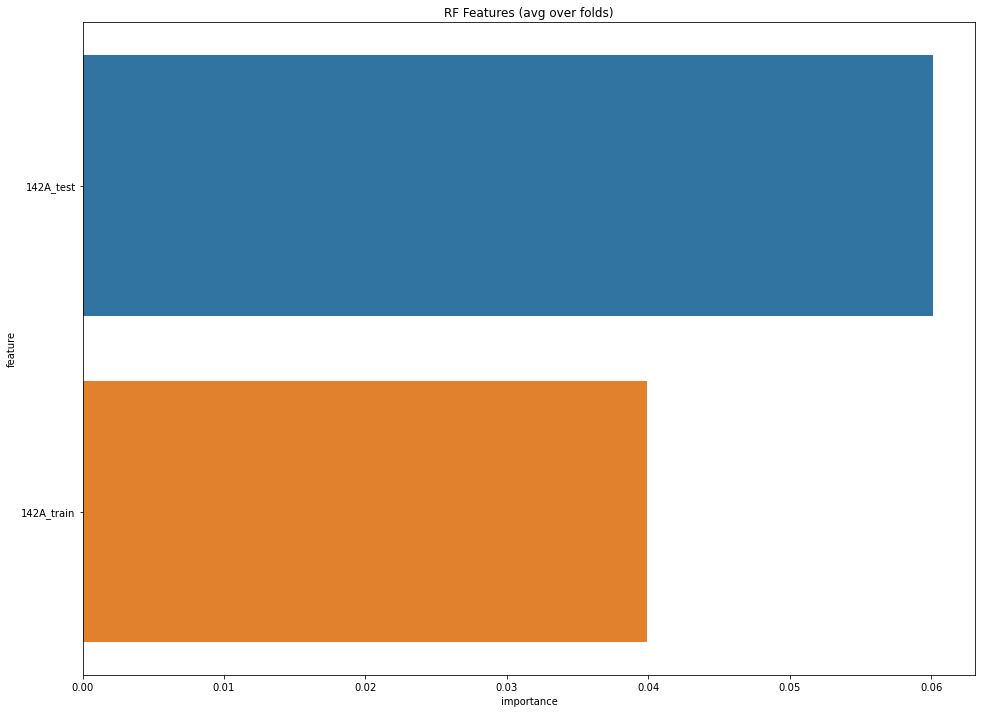

In [236]:

areas = []
metrics = []
for area in groups:
    group_range = groups[area]
    group_cols = [col for col in final_df.columns[4:] if int(re.match("\d*", col).group()) in group_range]
    print("Group",area)
#     print("Cols",group_cols)
    X = final_df[group_cols]
    y = final_df['acc']
    results, model = train_model(X,y,folds,params=None,model_type='rf')
    areas.append(area)
    metrics.append(results['metrics'])

In [228]:
group_results

,train,test,train,test,train,test,train,test,train,test,train,test,train,test,train,test,train,test
rmse,0.073878,0.10241,0.02745,0.074974,0.073063,0.111601,0.031393,0.082556,0.027183,0.06899,0.029334,0.07797,0.0875,0.118852,0.063432,0.101026,0.156374,0.157548


In [230]:
group_results = pd.concat(metrics)
group_results["group"] = areas

In [232]:
group_results.sort_values(by="test")

,train,test,group
rmse,0.027183,0.068990,order
rmse,0.027450,0.074974,nom_cat
rmse,0.029334,0.077970,simp_claus
rmse,0.031393,0.082556,verb_cat
rmse,0.063432,0.101026,lexicon
rmse,0.073878,0.102410,morphology
rmse,0.073063,0.111601,nom_synt
rmse,0.087500,0.118852,comp_sent
rmse,0.156374,0.157548,other


## Draft

In [36]:
# params = {
#         'max_depth':3,
#         'min_child_weight':1,
#         'scale_pos_weight':weight_ratio,
#         'objective':'binary'
# }

In [37]:
# split = int(0.9*final_df.shape[0])
# train = final_df.iloc[:split,:]
# test = final_df.iloc[split:,:]
# train.shape,test.shape

In [40]:
final_df.shape

(841, 320)

### XGB hyperparameter tuning - Random Search

In [176]:
xgb_model = xgb.XGBRegressor()
distributions = {
    "n_estimators":[2,5,10,50,100],
    "max_depth":[3,4,5,8,10],
    "min_child_weight":[1,2,5]
#     lambda:
    
}

exhaustive = 1
for k in distributions:
    exhaustive *= len(distributions[k])
    
print(exhaustive)

random_search = RandomizedSearchCV(xgb_model, distributions, cv=10,n_iter=exhaustive,random_state=0,scoring='neg_mean_squared_error')
search = random_search.fit(X,y)

pd.DataFrame.from_dict(search.cv_results_)

params = search.best_params_

75
